In [200]:
import cPickle as pickle
import numpy as np
import tensorflow as tf
import tarfile
import ntpath
import cPickle, gzip

In [201]:
data_dir = "."

def load_cifar_10_dataset():
    print "Opening CIFAR 10 dataset"
    dataset = {}
    with tarfile.open(data_dir + "/cifar-10-python.tar.gz", "r:gz") as tar:
        for member in tar.getmembers():
            if member.isfile():
                if "_batch" in member.name:
                    file_name = ntpath.basename(member.name)
                    f = tar.extractfile(member)
                    batch_dataset = cPickle.load(f) 
                    dataset[file_name] = batch_dataset
                elif member.name.endswith("batches.meta"):
                    f = tar.extractfile(member)
                    label_names = cPickle.load(f) 
                    dataset["meta"] = label_names
    print "Finished opening CIFAR 10 dataset"
    return dataset

def merge_datasets(dataset_one, dataset_two):
    return {
        "data": np.concatenate((dataset_one["data"], dataset_two["data"])),
        "labels": dataset_one["labels"] + dataset_two["labels"], 
    }

def get_merged_training_datasets(dataset_batches_dict):
    training_dataset_names = [ "data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4" ]
    training_datasets = map(lambda name: dataset_batches_dict[name], training_dataset_names)
    training_dataset_and_labels = reduce(merge_datasets, training_datasets)
    validation_dataset_and_labels = dataset_batches_dict["data_batch_5"]
    test_dataset_and_labels = dataset_batches_dict["test_batch"]
    return (
        np.asarray(training_dataset_and_labels["data"]), np.asarray(training_dataset_and_labels["labels"]),
        np.asarray(validation_dataset_and_labels["data"]), np.asarray(validation_dataset_and_labels["labels"]),
        np.asarray(test_dataset_and_labels["data"]), np.asarray(test_dataset_and_labels["labels"])
    )

dataset_batches_dict = load_cifar_10_dataset()
label_names = dataset_batches_dict["meta"]["label_names"]
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = get_merged_training_datasets(dataset_batches_dict)

print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Opening CIFAR 10 dataset
Finished opening CIFAR 10 dataset
Training set (40000, 3072) (40000,)
Validation set (10000, 3072) (10000,)
Test set (10000, 3072) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [202]:
image_size = 32
num_labels = 10
num_channels = 3 # RGB


def reformat(dataset, labels):
    #dataset = dataset.reshape(
    #  (-1, image_size, image_size, num_channels)).astype(np.float32)
    
    # the dataset is of a shape (*, num_channels * image_size * image_size) 
    # with the red values first, followed by the green, then blue.
    decimal_code_to_fraction_quotient = 255.0
    dataset = dataset / decimal_code_to_fraction_quotient
    x = dataset.reshape((-1, num_channels, image_size * image_size)) # break the channels into their own axes.
    y = x.transpose([0, 2, 1]) # This transpose the matrix by swapping the second and third axes, but not the first. This puts matching RGB values together
    reformated_dataset = y.reshape((-1, image_size, image_size, num_channels)).astype(np.float32) # Turn the dataset into a 4D tensor of a collection of images, with axes of width, height and colour channels.
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return reformated_dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (40000, 32, 32, 3) (40000, 10)
Validation set (10000, 32, 32, 3) (10000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [203]:
def get_best_step(steps_to_predictions, labels):
    best_accuracy = 0
    best_accuracy_step = 0
    for step, predictions in steps_to_predictions.iteritems():
        acc = accuracy(predictions, labels)
        steps_to_predictions[step] = predictions
        if acc > best_accuracy:
            best_accuracy = acc
            best_accuracy_step = step
    return best_accuracy, best_accuracy_step

def visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions):
    best_validation_accuracy, best_validation_step = get_best_step(steps_to_validation_predictions, valid_labels)
    print "The best validation accuracy was %s at step %s" % (best_validation_accuracy, best_validation_step)
    best_test_accuracy, best_test_step = get_best_step(steps_to_test_predictions, test_labels)
    print "The best test accuracy was %s at step %s" % (best_test_accuracy, best_test_step)
    
    best_prediction = steps_to_test_predictions[best_test_step]
    correct_prediction_indexes = []
    incorrect_prediction_indexes = []
    index = 0
    for accurate in np.argmax(best_prediction, 1) == np.argmax(test_labels, 1):
        if accurate:
            correct_prediction_indexes.append(index)
        else:
            incorrect_prediction_indexes.append(index)
        index += 1
    return correct_prediction_indexes, incorrect_prediction_indexes

%matplotlib inline

import matplotlib.pyplot as plt
from random import randint, shuffle

def get_index_of_one_hot_vector(one_hot_vector):
    for i in range(len(one_hot_vector)):
        if one_hot_vector[i] == 1.0:
            return i
    raise "Not a one_hot_vector"
    
def display_test_data(data_set, labels, data_index, figure, subplot_index, width=5, height=5):
    a = figure.add_subplot(width, height, subplot_index)
    data = data_set[data_index,:,:,:]
    reshaped_data = data.reshape((image_size, image_size,-1)).astype(np.float32)
    plt.axis("off")
    #plt.figure(figsize=(100, 100))
    plt.imshow(reshaped_data, cmap=plt.cm.hot)
    label = get_index_of_one_hot_vector(labels[data_index])
    a.set_title(label_names[label])
    
def display_random_data(data_set, labels, number_of_data=25):
    figure_size = math.ceil(pow(number_of_data, 0.5))
    figure = plt.figure()
    for i in range(number_of_data):
        data_index = randint(0, len(data_set) - 1)
        display_test_data(data_set, labels, data_index, figure, i, width=figure_size, height=figure_size)

    figure.subplots_adjust(hspace=1.5)

def display_data(dataset, labels, indexes, number_of_data=25):
    figure_size = math.ceil(pow(number_of_data, 0.5))
    figure = plt.figure()
    for i in range(number_of_data):
        display_test_data(dataset, labels, indexes[i], figure, i, width=figure_size, height=figure_size)

    figure.subplots_adjust(hspace=1.5)

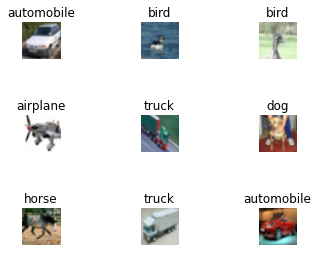

In [204]:
display_size = 9
index_start = 45
display_data(train_dataset, train_labels, range(index_start, index_start + display_size), number_of_data=display_size)

In [205]:
import math
import time

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def get_l2_loss(l2_lambda, layer_weights):
    return l2_lambda * sum(map(tf.nn.l2_loss, layer_weights))

def train_bigger_cnn(steps, learning_rate = 0.05, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.5, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96):
    print "Creating a convnet model with params: %s" % locals()
    print "Start time %s" % time.strftime("%H:%M")
    batch_size = 32
    patch_size = 5
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        dropout_keep_probability = tf.placeholder(tf.float32)

        initialised_weights_stddev = 0.1
        # Variables.
        layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        layer1_biases = tf.Variable(tf.zeros([feature_maps]))

        layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        layer2_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        

        conv_layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        #layel3_weights = tf.Variable(tf.truncated_normal(
        #    [image_size / 4 * image_size / 4 * feature_maps, number_of_hidden_neurons], stddev=initialised_weights_stddev))
        number_of_conv_layers = 3
        layer3_weights = tf.Variable(tf.truncated_normal(
            [int(math.ceil(image_size / (2.0 ** number_of_conv_layers)) * math.ceil(image_size / (2.0 ** number_of_conv_layers)) * feature_maps), number_of_hidden_neurons], stddev=initialised_weights_stddev))
        layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[number_of_hidden_neurons]))

        
        layer4_weights = tf.Variable(tf.truncated_normal(
            [number_of_hidden_neurons, num_labels], stddev=initialised_weights_stddev))
        layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[num_labels]))

        # Model.
        def model(data, add_dropout = False):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer1_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            
            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer2_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            
            conv = tf.nn.conv2d(hidden, conv_layer3_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer3_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            
            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            if add_dropout:
                hidden = tf.nn.dropout(hidden, dropout_keep_probability)
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, add_dropout = True)
        layer_weights = [layer1_weights, layer2_weights, conv_layer3_weights, layer3_weights, layer4_weights]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + get_l2_loss(l2_lambda, layer_weights))

        # Optimizer.
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(decayed_learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        test_prediction = tf.nn.softmax(model(tf_test_dataset))

        steps_to_validation_predictions = {}
        steps_to_test_predictions = {}
        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print "Initialized"
            for step in xrange(steps):
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_keep_probability: dropout_keep_prob}
                _, l, predictions = session.run(
                    [optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % 1000 == 0):
                    print "Minibatch loss at step", step, ":", l
                    print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
                    validation_predictions = valid_prediction.eval()
                    steps_to_validation_predictions[step] = validation_predictions
                    print "Validation accuracy at step %s: %.1f%%" % (step, accuracy(validation_predictions, valid_labels))
                if (step != 0 and step % 5000 == 0 and step != (steps - 1)):
                    test_predictions = test_prediction.eval()
                    steps_to_test_predictions[step] =  test_predictions
                    print "Test accuracy at step %s: %.1f%%" % (step, accuracy(test_predictions, test_labels))
            test_predictions = test_prediction.eval()
            steps_to_test_predictions[step] =  test_predictions
            print "Test accuracy at step %s: %.1f%%\n" % (step, accuracy(test_predictions, test_labels))
            print "End time %s" % time.strftime("%H:%M")
            return steps_to_validation_predictions, steps_to_test_predictions


**My goal is to achieve 75.86% test accuracy** or higher for the CIFAR-10 dataset. My stretch goal is 90% test accuracy.

My first naive adoption of the Not-MNIST conv net achieved ~26% after 5000 steps.

Creating a convnet model with params: {'number_of_hidden_neurons': 64, 'decay_steps': 10000, 'dropout_keep_prob': 0.9, 'feature_maps': 16, 'decay_rate': 0.96, 'steps': 85000, 'l2_lambda': 0.1, 'learning_rate': 0.001}
Start time 16:10
Initialized
Minibatch loss at step 0 : 160.803
Minibatch accuracy: 0.0%
Validation accuracy at step 0: 10.4%
Minibatch loss at step 1000 : 12.1836
Minibatch accuracy: 15.6%
Validation accuracy at step 1000: 19.2%
Minibatch loss at step 2000 : 10.3668
Minibatch accuracy: 15.6%
Validation accuracy at step 2000: 24.3%
Minibatch loss at step 3000 : 8.77621
Minibatch accuracy: 25.0%
Validation accuracy at step 3000: 25.7%
Minibatch loss at step 4000 : 7.44569
Minibatch accuracy: 28.1%
Validation accuracy at step 4000: 26.0%
Minibatch loss at step 5000 : 6.37141
Minibatch accuracy: 18.8%
Validation accuracy at step 5000: 31.0%
Test accuracy at step 5000: 30.8%
Minibatch loss at step 6000 : 5.77358
Minibatch accuracy: 28.1%
Validation accuracy at step 6000: 34.2%

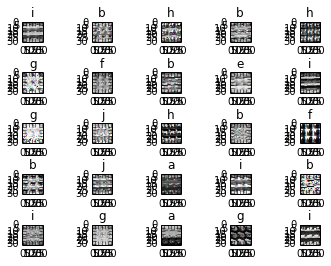

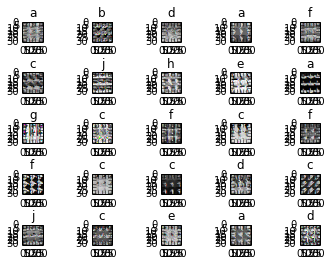

In [61]:
results = train_bigger_cnn(85000, learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

In [ ]:
# Increased the learning rate and nullified the decayed learning rate.
results = train_bigger_cnn(85000, learning_rate = 0.0015, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 1.0)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Creating a convnet model with params: {'number_of_hidden_neurons': 64, 'decay_steps': 10000, 'dropout_keep_prob': 0.9, 'feature_maps': 16, 'decay_rate': 1.0, 'steps': 85000, 'l2_lambda': 0.1, 'learning_rate': 0.0015}
Start time 23:06
Initialized
Minibatch loss at step 0 : 16.5049
Minibatch accuracy: 3.1%
Validation accuracy at step 0: 9.4%
Minibatch loss at step 1000 : 11.084
Minibatch accuracy: 12.5%
Validation accuracy at step 1000: 21.2%

In [ ]:
The best validation accuracy was 53.08 at step 83000
The best test accuracy was 52.94 at step 80000

In [ ]:
results = train_bigger_cnn(85000, learning_rate = 0.05, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 1.0)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictio